In [3]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [5]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [6]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


27033600/27018416 [==============================] - 0s 0us/step


2022/03/17 11:29:39 INFO mlflow.tracking.fluent: Experiment with name 'EfficientNetB1 con DataAugmentation (ImageNet)' does not exist. Creating a new experiment.


Epoch 1/25
257/257 [==============================] - 86s 250ms/step - loss: 2.3470 - accuracy: 0.5312 - val_loss: 1.2165 - val_accuracy: 0.6249
Epoch 2/25
257/257 [==============================] - 60s 232ms/step - loss: 1.4434 - accuracy: 0.6294 - val_loss: 1.0334 - val_accuracy: 0.6829
Epoch 3/25
257/257 [==============================] - 60s 232ms/step - loss: 1.1657 - accuracy: 0.6576 - val_loss: 0.9819 - val_accuracy: 0.7029
Epoch 4/25
257/257 [==============================] - 60s 234ms/step - loss: 1.0607 - accuracy: 0.6694 - val_loss: 0.9645 - val_accuracy: 0.6936
Epoch 5/25
257/257 [==============================] - 60s 232ms/step - loss: 0.9984 - accuracy: 0.6857 - val_loss: 0.9348 - val_accuracy: 0.6970
Epoch 6/25
257/257 [==============================] - 60s 232ms/step - loss: 0.9776 - accuracy: 0.6867 - val_loss: 0.8859 - val_accuracy: 0.7151
Epoch 7/25
257/257 [==============================] - 60s 231ms/step - loss: 0.9675 - accuracy: 0.6950 - val_loss: 0.9353 - val_ac

2022/03/17 11:41:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


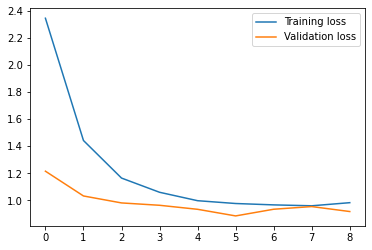

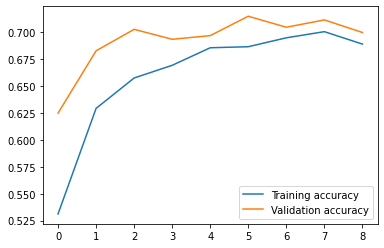

In [7]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip()
])

## Vamos a entrenar usando la red EfficietNetB1
base_model = tf.keras.applications.EfficientNetB1(include_top=False,
                                                  weights='imagenet',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  augmentation,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=1e-2)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB1 con DataAugmentation (ImageNet)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=25,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/10
257/257 [==============================] - 244s 880ms/step - loss: 1.4642 - accuracy: 0.5872 - val_loss: 3.1300 - val_accuracy: 0.3945
Epoch 2/10
257/257 [==============================] - 223s 865ms/step - loss: 0.7336 - accuracy: 0.7635 - val_loss: 0.5206 - val_accuracy: 0.8237
Epoch 3/10
257/257 [==============================] - 223s 867ms/step - loss: 0.5566 - accuracy: 0.8112 - val_loss: 0.3919 - val_accuracy: 0.8651
Epoch 4/10
257/257 [==============================] - 224s 871ms/step - loss: 0.4723 - accuracy: 0.8366 - val_loss: 0.3565 - val_accuracy: 0.8777
Epoch 5/10
257/257 [==============================] - 223s 868ms/step - loss: 0.3865 - accuracy: 0.8620 - val_loss: 0.3503 - val_accuracy: 0.8811
Epoch 6/10
257/257 [==============================] - 223s 866ms/step - loss: 0.3424 - accuracy: 0.8751 - val_loss: 0.3170 - val_accuracy: 0.8958
Epoch 7/10
257/257 [==============================] - 224s 869ms/step - loss: 0.3017 - accuracy: 0.8938 - val_loss: 0.3251 -

2022/03/17 12:23:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


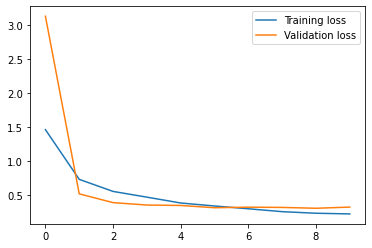

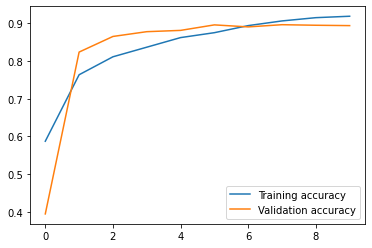

In [8]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                    epochs=10,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [9]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9  9 15]


In [10]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB1_ImageNet.csv', index=False)
files.download('EfficientNetB1_ImageNet.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>